In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import  adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import  ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [129]:
data = pd.read_csv('electricity_consumption.csv')
data.head()

,Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
0,2016-01-01,365,1423.5,219.0,247.73,31
1,2016-02-01,292,1138.8,175.2,234.11,31
2,2016-03-01,130,507.0,78.0,123.85,29
3,2016-04-01,117,456.3,70.2,111.22,29
4,2016-05-01,136,530.4,81.6,118.37,29


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bill_Date      53 non-null     object 
 1   On_peak        53 non-null     int64  
 2   Off_peak       53 non-null     float64
 3   Usage_charge   53 non-null     float64
 4   Billed_amount  53 non-null     float64
 5   Billing_days   53 non-null     int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.6+ KB


In [131]:
data['Date'] = pd.to_datetime(data.Bill_Date)

In [132]:
data = data.set_index('Date')
data.head()

,Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
Date,,,,,,
2016-01-01,2016-01-01,365,1423.5,219.0,247.73,31
2016-02-01,2016-02-01,292,1138.8,175.2,234.11,31
2016-03-01,2016-03-01,130,507.0,78.0,123.85,29
2016-04-01,2016-04-01,117,456.3,70.2,111.22,29
2016-05-01,2016-05-01,136,530.4,81.6,118.37,29


In [133]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data=data.drop(columns='Bill_Date')
data.head()

,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days,year,month,day
Date,,,,,,,,
2016-01-01,365,1423.5,219.0,247.73,31,2016,1,1
2016-02-01,292,1138.8,175.2,234.11,31,2016,2,1
2016-03-01,130,507.0,78.0,123.85,29,2016,3,1
2016-04-01,117,456.3,70.2,111.22,29,2016,4,1
2016-05-01,136,530.4,81.6,118.37,29,2016,5,1


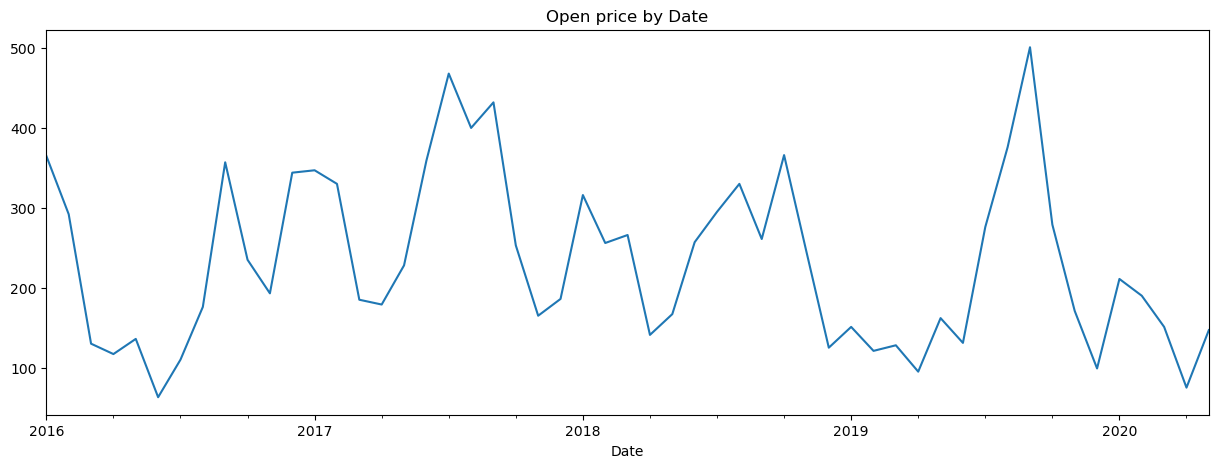

In [134]:
data['On_peak'].plot(figsize=(15,5))
plt.title("Open price by Date")
plt.show()

In [135]:
result = adfuller(data['On_peak'])
print(f"On-peak p-value: {result[1]}")

On-peak p-value: 0.046609411528733075


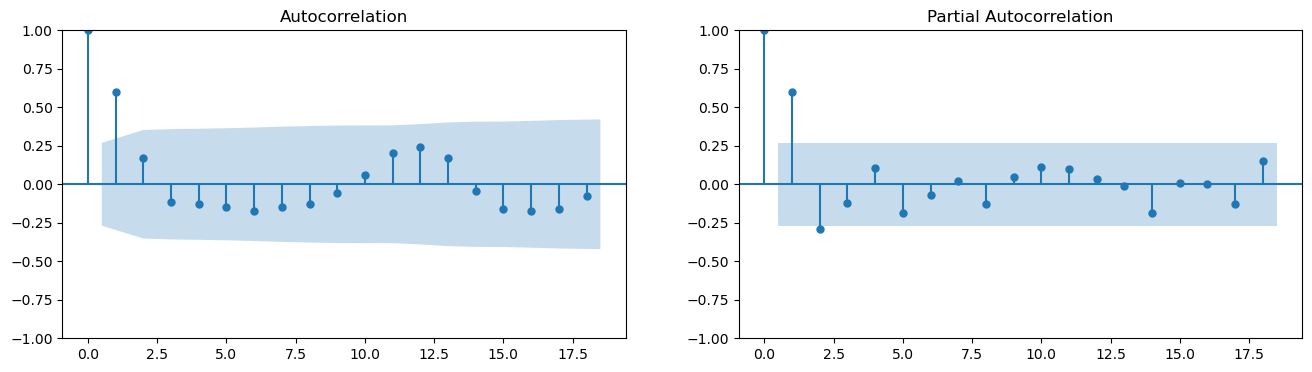

In [136]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['On_peak'], ax=axes[0])
plot_pacf(data['On_peak'], ax=axes[1])
plt.show()

In [137]:
train = data['On_peak'].loc[data.index < '2019-05-01'] 
test = data['On_peak'].loc[data.index >= '2019-05-01'] 

In [138]:
test

Date
2019-05-01    162
2019-06-01    131
2019-07-01    276
2019-08-01    376
2019-09-01    501
2019-10-01    279
2019-11-01    171
2019-12-01     99
2020-01-01    211
2020-02-01    190
2020-03-01    151
2020-04-01     75
2020-05-01    147
Name: On_peak, dtype: int64

In [139]:
train = train.asfreq('MS')
test = test.asfreq('MS')
model = sm.tsa.arima.ARIMA(train, order=(1,0,1))
model_fit = model.fit()

In [140]:
arima_forecast = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
arima_forecast.index = test.index

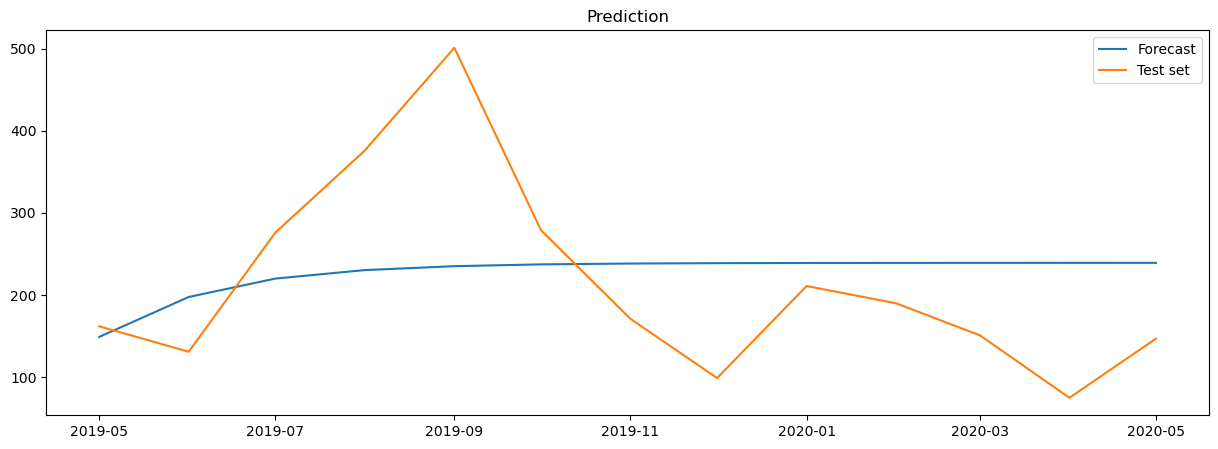

In [141]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(arima_forecast)
plt.plot(test)
plt.legend(['Forecast', 'Test set'])
plt.title('Prediction')
plt.show()

In [142]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae_arima = mean_absolute_error(test.values, arima_forecast)
rmse_arima = root_mean_squared_error(test.values, arima_forecast)
mape_arima = (abs((test.values - arima_forecast) / test.values).mean()) * 100
print(f"ARIMA:\n MAE: {mae_arima} \n RMSE: {rmse_arima} \n MAPE: {mape_arima}\n")

ARIMA:
 MAE: 93.67120248266049 
 RMSE: 114.99025361649801 
 MAPE: 57.37185321203187



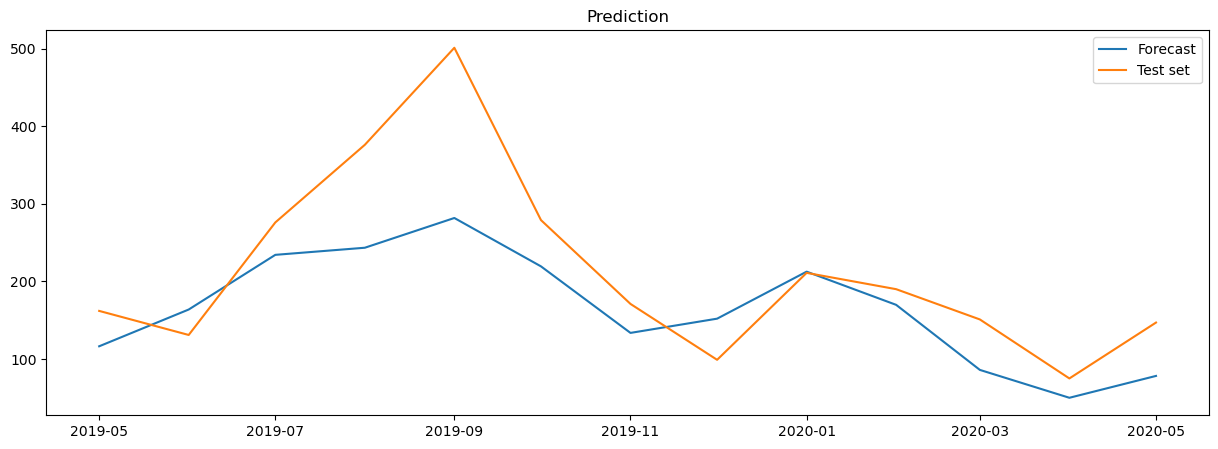

In [143]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add')
model_fit = model.fit()

hw_add_forecast = model_fit.forecast(steps=len(test))
hw_add_forecast.index = test.index

plt.figure(figsize=(15, 5))
plt.plot(hw_add_forecast)
plt.plot(test)
plt.legend(['Forecast', 'Test set'])
plt.title('Prediction')
plt.show()
plt.show()

In [144]:
mae_hw_add = mean_absolute_error(test.values, hw_add_forecast)
rmse_hw_add= root_mean_squared_error(test.values, hw_add_forecast)
mape_hw_add = (abs((test.values - hw_add_forecast) / test.values).mean()) * 100
print(f"Holt-Winters Additive:\n MAE: {mae_hw_add} \n RMSE: {rmse_hw_add} \n MAPE: {mape_hw_add}\n")

Holt-Winters Additive:
 MAE: 61.72466490493457 
 RMSE: 82.42091466961786 
 MAPE: 29.11407548300607



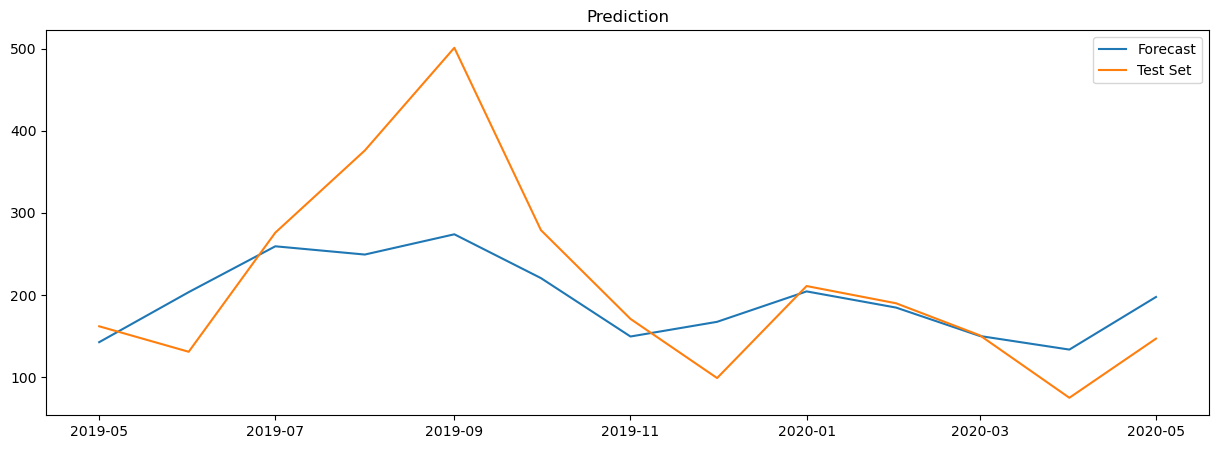

In [145]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12, trend='mul')
model_fit = model.fit()

hw_mul_forecast = model_fit.forecast(steps=len(test))
hw_mul_forecast.index = test.index

plt.figure(figsize=(15, 5))
plt.plot(hw_mul_forecast, label='Forecast')  
plt.plot(test, label='Test Set')            
plt.legend()
plt.title('Prediction')
plt.show()

In [146]:
mae_hw_mul = mean_absolute_error(test.values, hw_mul_forecast)
rmse_hw_mul= root_mean_squared_error(test.values, hw_mul_forecast)
mape_hw_mul = (abs((test.values - hw_mul_forecast) / test.values).mean()) * 100
print(f"Holt-Winters Multiplicative:\n MAE: {mae_hw_mul} \n RMSE: {rmse_hw_mul} \n MAPE: {mape_hw_mul}\n")

Holt-Winters Multiplicative:
 MAE: 56.337772953143535 
 RMSE: 82.33839889102863 
 MAPE: 28.77145124770536

